In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import LinearSVR, SVC, SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import xgboost

In [4]:
df = pd.read_csv("../data/data.csv")
df = df.copy()
data_raw = df.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 2.4+ MB


In [6]:
# null_d = df[df["D_h [mm]"].isnull() & df["D_e [mm]"].isnull()]["id"]
# df.drop(null_d, inplace=True, axis=0)
# null_d

In [26]:
sns.heatmap(df)

ValueError: could not convert string to float: 'Thompson'

In [8]:
print(df.groupby(['geometry', 'D_e [mm]', 'D_h [mm]'])['id'].count().sort_values(ascending=False))

geometry  D_e [mm]  D_h [mm]
tube      10.3      10.3        1880
          10.8      10.8        1790
          4.7       4.7         1754
          1.9       1.9         1723
          7.7       7.7         1642
                                ... 
          10.0      40.0           1
annulus   12.8      42.3           1
plate     10.8      10.8           1
          10.0      10.0           1
annulus   11.3      4.6            1
Name: id, Length: 89, dtype: int64


In [9]:
df_aux = df[df["geometry"]=="plate"]
df_aux.dropna(inplace=True)
df_aux[df_aux ["D_e [mm]"] == df_aux ["D_h [mm]"]]

C:\Users\VersusPC\AppData\Local\Temp\ipykernel_33224\2861432864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux.dropna(inplace=True)


,id,author,geometry,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
4476,4476,Thompson,plate,15.51,2984.0,-0.0109,1.9,1.9,10.0,7.6
6412,6412,Williams,plate,15.17,1335.0,-0.0187,9.5,9.5,1836.0,2.1
16858,16858,Richenderfer,plate,0.51,2000.0,-0.0407,1.9,1.9,10.0,8.1
28605,28605,Richenderfer,plate,0.51,5600.0,-0.0373,15.9,15.9,10.0,14.7


In [10]:
tube_error = 32/(6296+32)
annulus_error = 16/(1298+16)
plate_error = 4/(164+4)

print(f"tube error: {tube_error:.2}, annulus error: {annulus_error:.2}, plate error: {plate_error:.2}")

tube error: 0.0051, annulus error: 0.012, plate error: 0.024


Sabiendo esto, imputamos geometry, D_e y D_h sabiendo que: 
- si geometry = tube entonces D_e = D_h
- si geometry = plate entonces D_e = 15 | D_h = 120
- si geometry = annulus entonces LinearRegression

In [11]:
# def value_changer(row):   
#     if row["D_h [mm]"] == 120 or row["D_e [mm]"] == 15:
#         row["geometry"] = "plate"
#     elif row["D_e [mm]"] == row["D_e [mm]"]:
#         row["geometry"] = "tube"
#     elif row["geometry"] == "tube":
#         row["D_e [mm]"] = row["D_e [mm]"]
#     elif row["geometry"] == "plate":
#         row["D_e [mm]"] = 15
#         row["D_h [mm]"] = 120
#     return row

# df.apply(value_changer, axis=1)

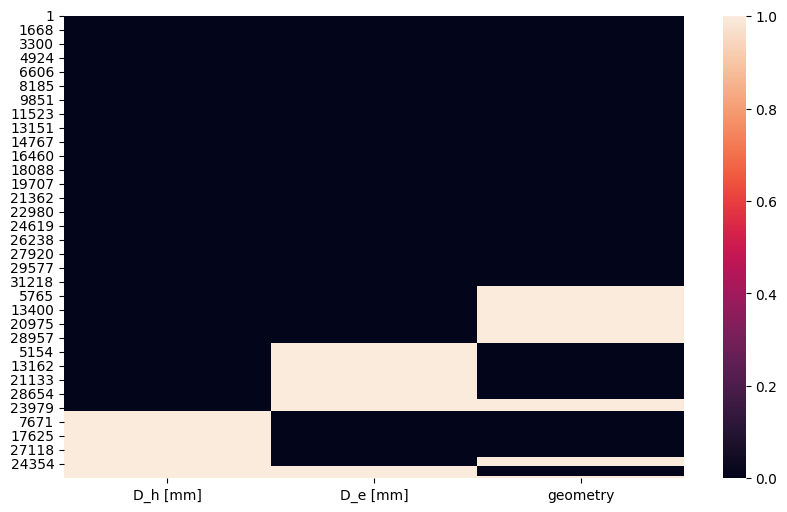

In [12]:
def plot_null_heatmap(df, cols_sort=None):
    plt.figure(figsize=(10, 6))
    if cols_sort is not None:
        sns.heatmap(df.isnull().sort_values(by=cols_sort), cbar=True)
    else:
        sns.heatmap(df.isnull(), cbar=True)
    plt.show()
plot_null_heatmap(data_raw.loc[:,["D_h [mm]", "D_e [mm]", "geometry"]], cols_sort=["D_h [mm]", "D_e [mm]", "geometry"])

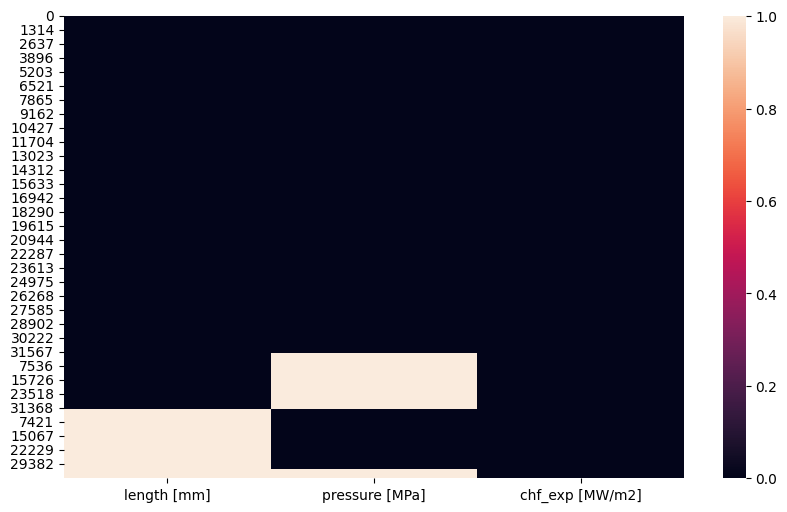

In [13]:
def plot_null_heatmap(df, cols_sort=None):
    plt.figure(figsize=(10, 6))
    if cols_sort is not None:
        sns.heatmap(df.isnull().sort_values(by=cols_sort), cbar=True)
    else:
        sns.heatmap(df.isnull(), cbar=True)
    plt.show()
plot_null_heatmap(data_raw.loc[:,["length [mm]", "pressure [MPa]", "chf_exp [MW/m2]"]], cols_sort=["length [mm]", "pressure [MPa]", "chf_exp [MW/m2]"])

# División dataframes para modelos preprocesado

## Target

In [14]:
target = df.loc[:,["id", "x_e_out [-]"]]
target = target[target["x_e_out [-]"].isnull()]

target.to_csv("../data/target.csv", index=False)

### Preprocesado de geometry

In [15]:
df['geometry_corrected'] = np.nan

df.loc[(df['D_h [mm]'] == df['D_e [mm]']), 'geometry_corrected'] = 'tube'
df.loc[((df['D_h [mm]'] == 120) & (df['D_e [mm]'] == 15)), 'geometry_corrected'] = 'plate'
df.loc[((df['geometry_corrected'].isna()) & (df['D_h [mm]'].notna()) & (df['D_e [mm]'].notna())), 'geometry_corrected'] = 'annulus'

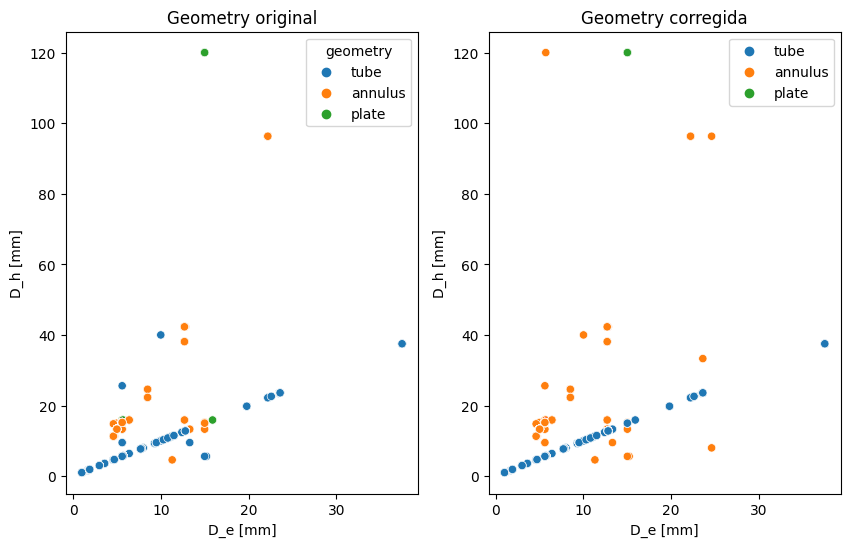

In [16]:
fig, axes = plt.subplots(1,2, figsize=(10, 6))

sns.scatterplot(data=df, x='D_e [mm]', y='D_h [mm]', hue='geometry', ax=axes[0])
axes[0].set_title('Geometry original')
sns.scatterplot(data=df, x='D_e [mm]', y='D_h [mm]', hue='geometry_corrected', ax=axes[1])
axes[1].set_title('Geometry corregida')

plt.legend()

plt.show()

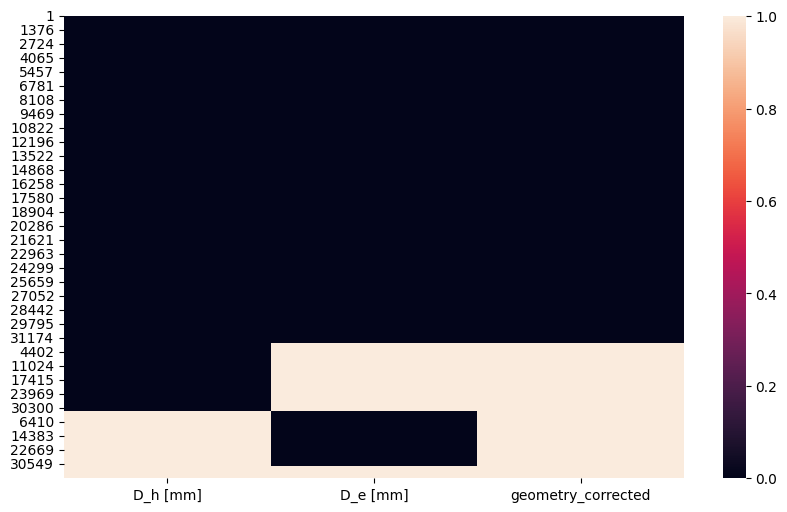

In [17]:
def plot_null_heatmap(df, cols_sort=None):
    plt.figure(figsize=(10, 6))
    if cols_sort is not None:
        sns.heatmap(df.isnull().sort_values(by=cols_sort), cbar=True)
    else:
        sns.heatmap(df.isnull(), cbar=True)
    plt.show()
plot_null_heatmap(df.loc[:,["D_h [mm]", "D_e [mm]", "geometry_corrected"]], cols_sort=["D_h [mm]", "D_e [mm]", "geometry_corrected"])

## Df 1 (variables geometría)

In [18]:
df_1 = df.loc[:,["id","D_h [mm]", "D_e [mm]", "geometry_corrected"]]
df_1.to_csv("../data/geometry.csv", index=False)

## DF 2 (variables calor)

In [19]:
df_2 = df.loc[:,["id","length [mm]", "pressure [MPa]", "chf_exp [MW/m2]"]]
df_2.to_csv("../data/heat.csv", index=False)

# Re-unión df y concat df original

In [20]:
imputed_geometry = pd.read_csv("../data/imputed_geometry.csv")
imputed_heat = pd.read_csv("../data/imputed_heat.csv")
original_df = pd.read_csv("../data/Data_CHF_Zhao_2020_ATE.csv")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       27192 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             26156 non-null  float64
 7   D_h [mm]             27055 non-null  float64
 8   length [mm]          26885 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
 10  geometry_corrected   22382 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 2.7+ MB


In [22]:
df.update(imputed_geometry.set_index('id').combine_first(df.set_index('id')))
df.update(imputed_heat.set_index('id').combine_first(df.set_index('id')))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31644 entries, 0 to 31643
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   31644 non-null  int64  
 1   author               26620 non-null  object 
 2   geometry             26144 non-null  object 
 3   pressure [MPa]       31644 non-null  float64
 4   mass_flux [kg/m2-s]  26853 non-null  float64
 5   x_e_out [-]          21229 non-null  float64
 6   D_e [mm]             31644 non-null  float64
 7   D_h [mm]             31644 non-null  float64
 8   length [mm]          31644 non-null  float64
 9   chf_exp [MW/m2]      31644 non-null  float64
 10  geometry_corrected   30254 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 2.7+ MB


In [23]:
final_df = pd.concat([df,original_df], axis=0)

In [24]:
final_df["mass_flux [kg/m2-s]"] = final_df["mass_flux [kg/m2-s]"].fillna(final_df["mass_flux [kg/m2-s]"].mean())
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33509 entries, 0 to 1864
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   33509 non-null  int64  
 1   author               28485 non-null  object 
 2   geometry             28009 non-null  object 
 3   pressure [MPa]       33509 non-null  float64
 4   mass_flux [kg/m2-s]  33509 non-null  float64
 5   x_e_out [-]          23094 non-null  float64
 6   D_e [mm]             33509 non-null  float64
 7   D_h [mm]             33509 non-null  float64
 8   length [mm]          33509 non-null  float64
 9   chf_exp [MW/m2]      33509 non-null  float64
 10  geometry_corrected   30254 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 3.1+ MB


In [25]:
final_df.to_csv("../data/final_data.csv", index=False)